<hr>
<br>

## Ensemble Classification

# Artificial Intelligence - 2nd Assignment

- Firstly, we import the necessary libraries, packages and methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Machine Learning
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import linear_model,preprocessing
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable

<hr>
<br>

## 1. Dataset Analysis and Review


Attributes:
 
Attribute | Type | Properties | Discrete vs Continuous |
| - | - | - | - |
| Distance from home | Ratio |  Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Distance from last transaction | Ratio | Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Ratio of purchased price to median purchased price | Ratio |  Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Repeat Retailer | Nominal (binary) | Distinctness | Discrete |
| Used chip (used credit card) | Nominal (binary) | Distinctness | Discrete | 
| Used pin (used pin number) | Nominal (binary) | Distinctness | Discrete |
| Online Order | Nominal (binary) | Distinctness | Discrete |


In [2]:
dataFrame = pd.read_csv('https://raw.githubusercontent.com/luisaraujo25/IART/main/IART-proj2/files/card_transdata.csv')
dataFrame.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


<hr>
<br>

- You can now find basic statistics about our problem.

In [3]:
dataFrame.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


<hr>
<br>

## Data Preprocessing

- First, we are checking if there are any duplicated data.
- If yes, we remove duplicated objects.
- For this specific dataset, there isn't any duplicated data as it can be watch in the following:

In [4]:
length = len(dataFrame)
dataFrame.drop_duplicates(keep = False)
cleanedDups = len(dataFrame)

print("Original dataset length: ", length)
print("Number of dups: ", length - cleanedDups)

Original dataset length:  1000000
Number of dups:  0


- Secondly, we detect outliers.

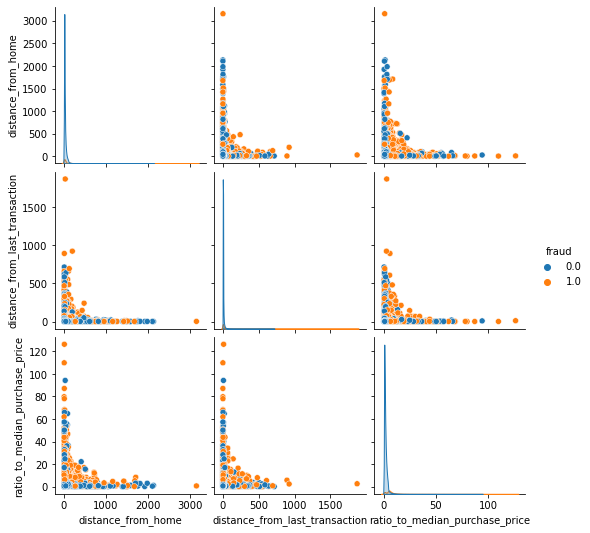

In [5]:
%matplotlib inline
dataFrame = dataFrame.sample(100000) #sample used for faster run-time of program
sns.pairplot(dataFrame, vars =["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"], hue = 'fraud')

- If there are any outliers for the given dataset, we remove them.

In [ ]:
#remove outliers
dataFrame = dataFrame[(dataFrame['distance_from_home'] <= 1900) ]
dataFrame = dataFrame[(dataFrame['distance_from_last_transaction'] <= 900)]
dataFrame = dataFrame[(dataFrame['ratio_to_median_purchase_price'] <= 75)]

%matplotlib inline

sns.pairplot(dataFrame, vars =["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"], hue = 'fraud')

- The last step of data preprocessing for our problem is removing "NA" or null values.

In [ ]:
print(dataFrame.isna().sum())
print(dataFrame.isnull().sum())
dataFrame = pd.read_csv('https://raw.githubusercontent.com/luisaraujo25/IART/main/IART-proj2/files/card_transdata.csv?token=GHSAT0AAAAAABU4MP55GLM3ECB2PEOE57AYYU6UTUQ', na_values=['NA'])
dataFrame.dropna()

<hr>
<br>

- In this step, we use a sample of our dataset since the given one is too long, reaching 1000000 objects.
- After that, we create two new datasets: one only containing fraudlent transactions (fraud attribute = 1) and another contaning only non-fraudlent transactions (fraud attribute = 0)

In [ ]:
#No fraud (class == 0) meaning legit transactions
#Fraud (class == 1) meaning fraudulent transactions

#Creating new data frames for No fraud and Fraud cases
no_fraud=dataFrame[dataFrame.fraud == 0]
fraud=dataFrame[dataFrame.fraud == 1]

#Resampling the original dataset with 10,000 datapoints
no_fraud_resample=no_fraud.sample(n=5000)
fraud_resample=fraud.sample(n=5000)

#Creating new dataset consisting of equal class occurence 
data=pd.concat([no_fraud_resample,fraud_resample],axis=0)

In [ ]:
#Splitting the dataset

#Creating dataframe for target
target=data['fraud']

#Creating dataframe for features
features=data.drop(columns=['fraud'],axis=1)


train_features,test_features,train_labels,test_labels = train_test_split(features,target,stratify=target,shuffle=True,random_state=56)

In [ ]:
#Standardising the dataset
scale=MinMaxScaler().fit(train_features)
train_features_scaled=scale.transform(train_features)
test_features_scaled=scale.transform(test_features)

<hr>
<br>

## Algorithms and Model Training

### Random Forest

In [ ]:
start_time = time.time()


data_all=[] #Creating empty list to store model evaluation values
model_name = 'Random Forest'
model = RandomForestClassifier()
param_rf={
    "n_estimators": range(2,15,2),
    "max_features": range(1,7),
    "max_depth": range(1,10)
}


random_rf = RandomizedSearchCV(estimator = model, 
                                param_distributions = param_rf, 
                                n_iter = 15, 
                                cv = 10,
                                scoring = 'accuracy', 
                                verbose = 1, 
                                n_jobs = -1,
                                random_state = 1)

random_rf.fit(train_features, train_labels)


model = random_rf.best_estimator_
crossval = cross_val_score(model,
                            train_features,
                            train_labels,
                            cv = 5,
                            scoring = 'accuracy')

scores = np.mean(crossval)

test_pred = model.predict(test_features)
test_recall = recall_score(test_labels, 
                            test_pred, 
                            pos_label = 1)
fpr, tpr, thresholds = roc_curve(test_labels, 
                                test_pred, 
                                pos_label = 1)
test_auc = auc(fpr, tpr)

end_time = time.time()


#### Random Forest Confusion Matrix

In [ ]:
test_pred = model.predict(test_features)
cm = confusion_matrix(test_labels, test_pred)
clr = classification_report(test_labels, test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, 
            annot = True, 
            vmin = 0, 
            fmt = 'g', 
            cbar = False, 
            cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix:Random Forest")
plt.show()
print(clr)

if accuracy_score(test_labels, test_pred) - scores < 1:
    result_model = 'Good Model'
    data_all.append([model_name,
                    scores,
                    accuracy_score(test_labels, test_pred),
                    test_recall, 
                    test_auc,
                    (end_time-start_time),
                    result_model])
else:
    result_model = 'Bad Model'
    data_all.append([model_name,
                    scores,
                    accuracy_score(test_labels, test_pred),
                    test_recall,
                    test_auc,
                    (end_time-start_time),
                    result_model])

#### Random Forest Running Time

In [ ]:
print("Running time: ", end_time-start_time)

<hr>
<br>

### Support Vector Machine

In [ ]:
start_time = time.time()

model_name='SVM'
model= SVC()
param_svm={
    "C":[100,10,1,0.1],
    "gamma": [10,1,0.1,0.001],
    "kernel": ['rbf']
    }

random_svm=RandomizedSearchCV(estimator=model, param_distributions=param_svm, n_iter = 15 , scoring='accuracy', cv = 10, verbose=2, n_jobs=-1,random_state=43)
random_svm.fit(train_features_scaled,train_labels)

model=random_svm.best_estimator_
crossval = cross_val_score(model,train_features_scaled,train_labels,cv=5,scoring='accuracy')
scores = np.mean(crossval)

test_pred=model.predict(test_features_scaled)
test_recall = recall_score(test_labels, test_pred, pos_label=1)
fpr, tpr, thresholds = roc_curve(test_labels, test_pred, pos_label=1)
test_auc = auc(fpr, tpr)


end_time = time.time()



#### Support Vector Machine Confusion Matrix

In [ ]:
test_pred=model.predict(test_features_scaled)
cm = confusion_matrix(test_labels, test_pred)
clr = classification_report(test_labels, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: SVM")
plt.show()
print("Classification Report:\n\n", clr)

if accuracy_score(test_labels,test_pred)-scores <1:
    result_model='Good Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,(end_time-start_time),result_model])
else:
    result_model='Bad Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,(end_time-start_time),result_model])

Defining a Function for Train and Test split - split is done on 80% train and 20% test (can be altered in test_size value). Initially done including all features.

#### Support Vector Machine Running Time

In [ ]:
print("Running time: ", end_time-start_time)

<hr>
<br>

### Decision Tree

In [ ]:
start_time = time.time()

model_name = 'Decision Tree'
des_tree_model = DecisionTreeClassifier()
drawing= des_tree_model.fit(train_features, train_labels)
y_test_pred = des_tree_model.predict(test_features)
y_train_pred = des_tree_model.predict(train_features)
Accuracy_Test=accuracy_score(test_labels, y_test_pred) * 100
Accuracy_Test= str(Accuracy_Test) + " %"
Accuracy_Train=accuracy_score(train_labels, y_train_pred) * 100
Accuracy_Train= str(Accuracy_Train) + " %"
Train_Data_Score=des_tree_model.score(train_features, train_labels) * 100
Train_Data_Score= str(Train_Data_Score) + " %"


#Construction of confusion matrix
confmat_train = confusion_matrix(y_train_pred, train_labels)
confmat_test =  confusion_matrix(y_test_pred, test_labels)
total=sum(sum(confmat_test))


#Calculation of Specificity
#Specificity = TN/(TN+FP)
sp = confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) * 100
sp= str(sp) + " %"


#Calculation of sensitivity
#Sensitivity= TP/(TP+FN)
sensi = confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) * 100
sensi= str(sensi) + " %"

end_time = time.time()

crossval = cross_val_score(des_tree_model,train_features_scaled,train_labels,cv=5,scoring='accuracy')
scores = np.mean(crossval)

test_recall = recall_score(test_labels, y_test_pred, pos_label=1)
fpr,tpr,thresholds = roc_curve(test_labels, test_pred, pos_label=1)
test_auc = auc(fpr,tpr)

if accuracy_score(test_labels,test_pred)-scores <1:
    result_model='Good Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,y_test_pred),test_recall,test_auc,(end_time-start_time),result_model])
else:
    result_model='Bad Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,y_test_pred),test_recall,test_auc,(end_time-start_time),result_model])

#### Decision Tree Confusion Matrix

In [ ]:
# Confusion matrix of the Decision Tree
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_confusionmat(cm, lab, test_or_train):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    f = ax.matshow(cm, cmap=plt.cm.turbo)
    plt.title('Confusion Matrix of the ' + test_or_train +' Decision Tree \n')
    fig.colorbar(f)
    ax.set_xticklabels([''] + lab)
    ax.set_yticklabels([''] + lab)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    s = [['TP','FN'], ['FP', 'TN']]
    for k in range(2):
        for l in range(2):
            plt.text(l,k, str(cm[k][l]))
    plt.show()

In [ ]:
plot_confusionmat(confmat_train, ["0","1"], "Training")
plot_confusionmat(confmat_test, ["0","1"], "Testing")

#### Decision Tree Drawing

In [ ]:
plt.figure(figsize=[60,40])
tree.plot_tree(des_tree_model,fontsize=20, rounded=True,impurity=True, precision=2)
#tree.plot_tree(drawing,fontsize=20, rounded=True,impurity=True, precision=2)
plt.show()

<hr>
<br>

### Logisitic Regression

In [ ]:
start_time = time.time()

model_name='Logistic Regression'
model= LogisticRegression(max_iter=1000)
param_lr={
    "solver": ['newton-cg','lbfgs','liblinear'],
    "C":[100, 10, 1.0, 0.1, 0.01],
    "penalty":['l2']
}
random_lr=RandomizedSearchCV(estimator=model, param_distributions=param_lr, n_iter = 15 , scoring='accuracy', cv = 10, verbose=2, n_jobs=-1,random_state=27)
random_lr.fit(train_features_scaled,train_labels)
model=random_lr.best_estimator_
crossval = cross_val_score(model,train_features_scaled,train_labels,cv=5,scoring='accuracy')
scores = np.mean(crossval)

test_pred=model.predict(test_features_scaled)
test_recall = recall_score(test_labels, test_pred, pos_label=1)
fpr,tpr,thresholds = roc_curve(test_labels, test_pred, pos_label=1)
test_auc = auc(fpr,tpr)

end_time = time.time()

#### Logistic Regression Running Time

In [ ]:
print("Running time: ", end_time-start_time)

#### Logistic Regression Confusion Matrix

In [ ]:
test_pred=model.predict(test_features_scaled)
cm = confusion_matrix(test_labels, test_pred)
clr = classification_report(test_labels, test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix:Log Reg")
plt.show()
print("Classification Report:\n----------------------\n", clr)

if accuracy_score(test_labels,test_pred)-scores <1:
    result_model='Good Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,(end_time-start_time),result_model])
else:
    result_model='Bad Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,(end_time-start_time),result_model])

### Ensemble Classification

In [ ]:
models=['Random Forest', 'SVM', 'Decision Tree', 'Logisitic Regression']
pd_scores=pd.DataFrame(data_all,columns=['model','train score','test score','test recall','test_auc','run time','Remark'])
print(pd_scores)

In [ ]:
#Train Score 
  
fig = plt.figure(figsize = (10, 5))

train_score_val=[]
 
for i in data_all:
        train_score_val.append(i[1])
# creating the bar plot
plt.bar(models, train_score_val, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Train Score")
plt.title("Train Score per Model")
plt.show()

In [ ]:
#Test Score 
  
fig = plt.figure(figsize = (10, 5))

test_score_val=[]
 
for i in data_all:
        test_score_val.append(i[2])
# creating the bar plot
plt.bar(models, test_score_val, color ='pink',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Test Score")
plt.title("Test Score per Model")
plt.show()

In [ ]:
#Test Score 
  
fig = plt.figure(figsize = (10, 5))

test_recall_val=[]
 
for i in data_all:
        test_recall_val.append(i[3])
# creating the bar plot
plt.bar(models, test_recall_val, color ='green',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Test Recall")
plt.title("Test Recall per Model")
plt.show()

In [ ]:
#Test Score 
  
fig = plt.figure(figsize = (10, 5))

test_auc_val=[]
 
for i in data_all:
        test_auc_val.append(i[4])
# creating the bar plot
plt.bar(models, test_auc_val, color ='blue',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Area Under Curve (%)")
plt.title("Area Under Curve per Model")
plt.show()

In [ ]:
#Test Score 
  
fig = plt.figure(figsize = (10, 5))

run_time_val=[]
 
for i in data_all:
        run_time_val.append(i[5])
# creating the bar plot
plt.bar(models, run_time_val, color ='green',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.title("Run Time per Model")
plt.show()

<strong>Conclusions</strong><br>
Comparing all the algorithms side by side, the first think that we noticed is the SVM run time was significantly higher relative to the others thus making it the less time-efficient algorithm of the 4. Upon further inspection of the values obtained, we verified that the decision tree and random forest are the ones that obtained the best scores but of those two, decisions tree algorithm is quite faster ( 8.02s vs 0.02s).